# Feature detection

This notebook shows the research process of replacing HOG with smarter SIFT feature detection in our ecocup classifier.

## Toy example

In [5]:
import matplotlib.pyplot as plt

from skimage import data
from skimage import transform
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, plot_matches, SIFT


In [3]:
img1 = rgb2gray(data.astronaut())

In [4]:
descriptor_extractor = SIFT()
descriptor_extractor.detect_and_extract(img1)

keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors


Text(0.5, 1.0, 'SIFT keypoints')

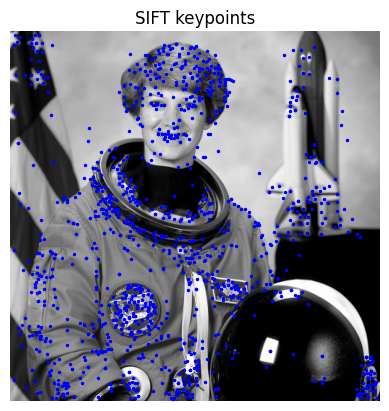

In [5]:
# plot keypoints
fig, ax = plt.subplots()
plt.gray()

ax.imshow(img1)
ax.plot(keypoints1[:, 1], keypoints1[:, 0], '.b', markersize=3)
ax.axis('off')
ax.set_title('SIFT keypoints')

In [6]:
descriptors1

array([[ 20,  19, 107, ...,   0,   8,  31],
       [  0,   0,   0, ...,   3,   9,  82],
       [  0,   0,   0, ...,   0,   0,  25],
       ...,
       [  0,   4,   4, ...,   4,   1,   4],
       [ 97, 118,   0, ...,   3,  12,   7],
       [ 34,   7,  11, ...,  99,  34,  17]], dtype=uint8)

## K-means clustering of SIFT features

We want to cluster the SIFT features to classify the images. We will compute the SIFT features for all images in the dataset and then cluster them using k-means.

### Compute SIFT features for all images

In [3]:
import os
import numpy as np
from skimage import io
from tqdm.notebook import tqdm
from sklearn.utils import check_random_state

In [6]:
# load images
pos_images = []
for file in os.listdir('data/augmented_images'):
    if file.endswith('.jpg'):
        pos_images.append(rgb2gray(io.imread('data/augmented_images/' + file)))

neg_images = []
for file in os.listdir('data/negative_images'):
    if file.endswith('.jpg'):
        neg_images.append(rgb2gray(io.imread('data/negative_images/' + file)))

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

No features found in 214 images


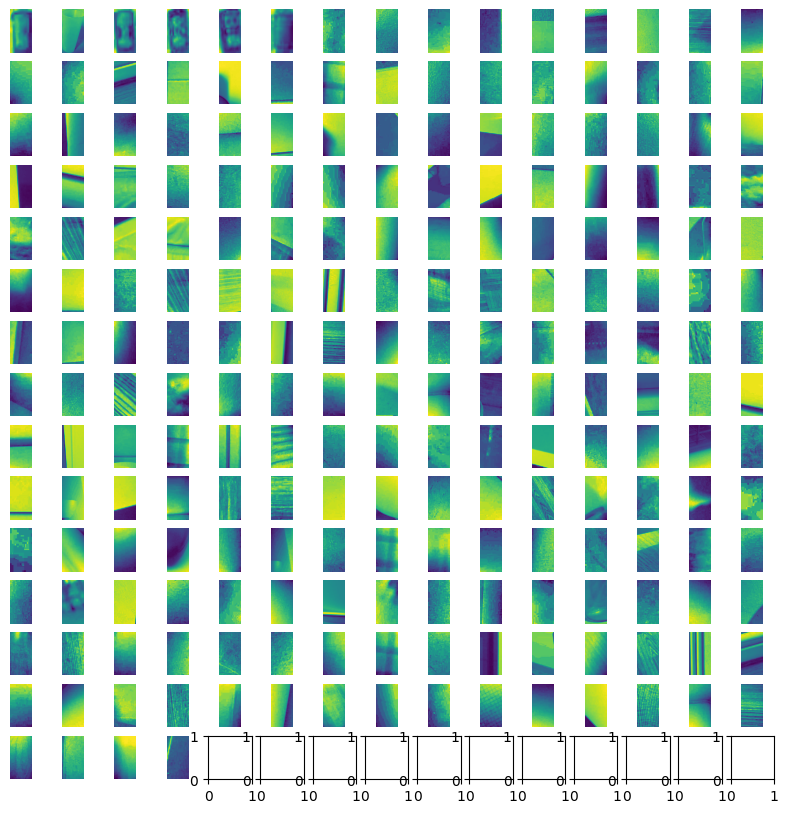

In [7]:
# compute SIFT features
descriptor_extractor = SIFT()

errored_images = []
pos_descriptors = []
pos_features = []
for img in tqdm(pos_images):
    try:
        descriptor_extractor.detect_and_extract(img)
    except:
        errored_images.append(img)
        continue
    pos_descriptors.append(descriptor_extractor.descriptors)

neg_descriptors = []
neg_features = []
for img in tqdm(neg_images):
    try:
        descriptor_extractor.detect_and_extract(img)
    except:
        errored_images.append(img)
        continue
    neg_descriptors.append(descriptor_extractor.descriptors)

# plot errored images
print(f'No features found in {len(errored_images)} images')
square = int(np.ceil(np.sqrt(len(errored_images))))
fig, ax = plt.subplots(square, square, figsize=(10, 10))
for i, img in enumerate(errored_images):
    ax[i // square, i % square].imshow(img)
    ax[i // square, i % square].axis('off')

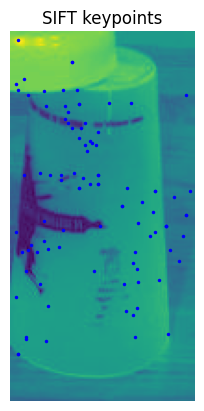

In [8]:
# plot an example of SIFT features
fig = plt.figure()
plt.imshow(pos_images[12])
plt.plot(descriptor_extractor.keypoints[:, 1], descriptor_extractor.keypoints[:, 0], '.b', markersize=3)
plt.axis('off')
plt.title('SIFT keypoints')
plt.show()

In [9]:
np.concatenate(pos_descriptors + neg_descriptors).shape

(98984, 128)

In [10]:
from sklearn.cluster import MiniBatchKMeans
random_state = check_random_state(None)
dictionary = MiniBatchKMeans(
            n_clusters=1000, random_state=random_state
        )
dictionary.fit(np.concatenate(pos_descriptors + neg_descriptors))
X = []
for descr_img in tqdm(pos_descriptors+neg_descriptors):
    X.append(np.histogram(
        dictionary.predict(descr_img), bins=range(dictionary.n_clusters), density=True
    )[0])

/Users/pierreadorni/Documents/ecocup_detection/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/1225 [00:00<?, ?it/s]

In [22]:
X = np.array(X)
X.shape

(1225, 999)

we now have a feature vector of 999 visual words for each image. We can now train a classifier on this data.

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

labels = np.concatenate([np.ones(len(pos_descriptors)), np.zeros(len(neg_descriptors))])
X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42)

In [25]:
# random forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {acc:.2f}")

Validation accuracy: 0.81


In [29]:
# SVM
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {acc:.2f}")

Validation accuracy: 0.80


In [28]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {acc:.2f}")

Validation accuracy: 0.64
